![title](images/header.png)

# Vc - Supervised Subsampling to extract points for visual interpretation 
-------
Using the outputs from Script 5b, the change probability is divided into 3 strata, which are proportionally sampled for validation
You can use this script to export samples as csv to create your own CEO projects
This may be run with an m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

### 1. read output file from script 5b

In [39]:
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_2015_2020_model.csv')
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_2015_2020_model.csv')
esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_1520_model.csv')
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_2015_2020_model.csv')
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_2015_2020_model.csv')
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_2015_2020_model.csv')
len(esbae_points)

291595

In [40]:
esbae_points.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd',
       ...
       'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520',
       'simple_combined', 'kmeans_chg', 'kmeans_def', 'kmeans_deg', 'PLOTID',
       'LON', 'LAT'],
      dtype='object', length=101)

In [41]:
# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(esbae_points['LON'], esbae_points['LAT'])]

# Create a GeoDataFrame by combining the DataFrame with the geometry
gdf = gpd.GeoDataFrame(esbae_points, geometry=geometry)

# Print the GeoDataFrame
#print(gdf)

In [42]:
joined_df = gdf

### 2. Stratify with Kmeans and select the number of points you want to sample for validation with CEO

In [43]:
sample_size_no = 10000

In [44]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [45]:
joined_df = joined_df.rename(columns={"stratum": "kmeans_chg_1520"})

,Nh,mean,SD,div,stratum,neyman,proportional
0,188055,0.068299,0.035759,6724.630587,1,4936,6449
1,82331,0.203594,0.054214,4463.459787,2,3276,2823
2,21209,0.474795,0.114728,2433.275104,3,1786,727


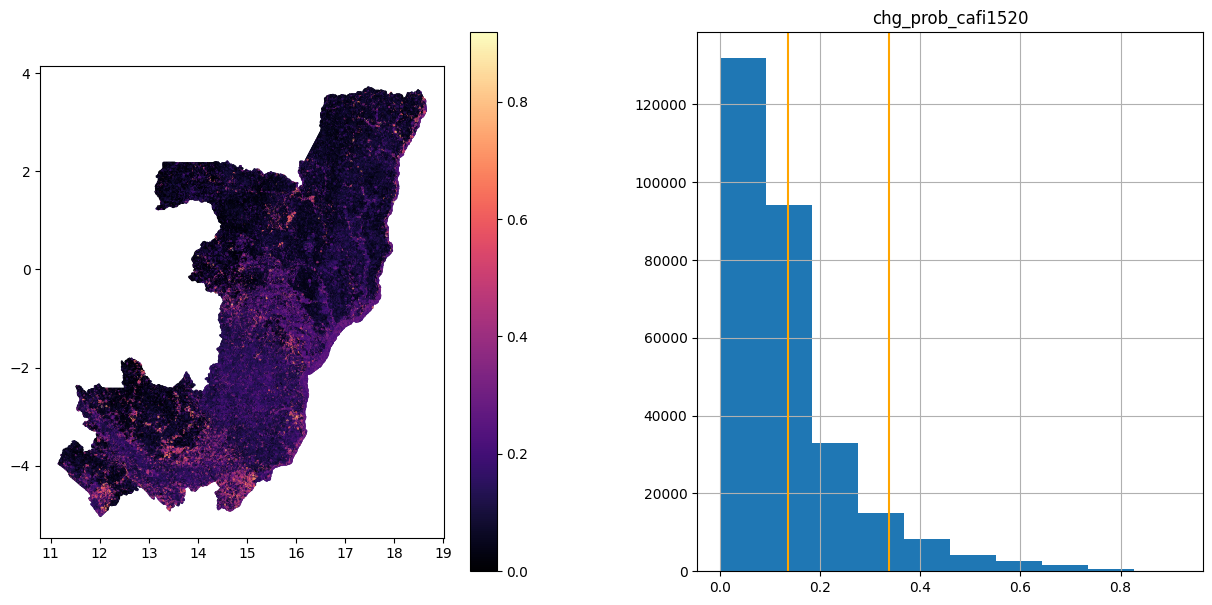

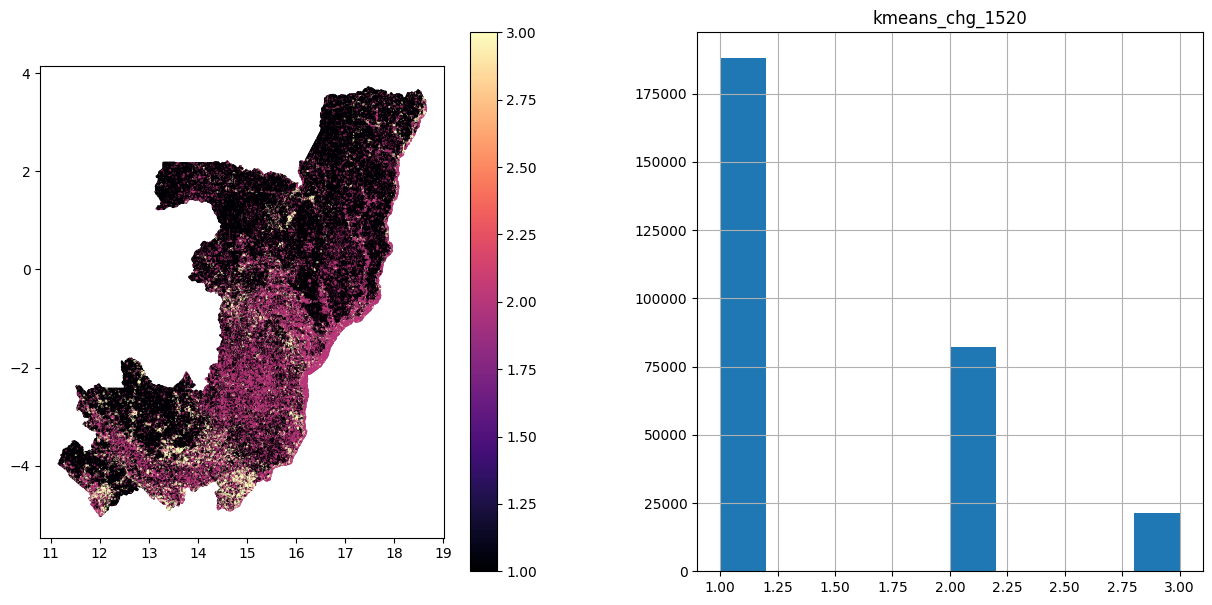

In [46]:
joined_df, sample_df = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=3, sample_size=sample_size_no)
h.plot_cluster(joined_df, prob_column='chg_prob_cafi1520', strata_column='kmeans_chg_1520')
fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_chg_1520', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_chg_1520', ax=ax[1])
sample_df

In [47]:
from sampling_handler.sampling import sfc

def select_with_space_filling_curve(test_df, samples, strata_column='kmeans_chg_1520'):
    dfs = []
    for stratum in test_df[strata_column].unique():
        print(stratum)
        dfs.append(sfc.sfc_subsample(
            gdf = test_df[test_df[strata_column] == stratum],
            target_point_size = samples.neyman[samples.stratum == stratum].values[0]
        ))
        
    return pd.concat(dfs)

samples = select_with_space_filling_curve(joined_df, samples) 

1
2
3


#### plot a map of the points

<Axes: >

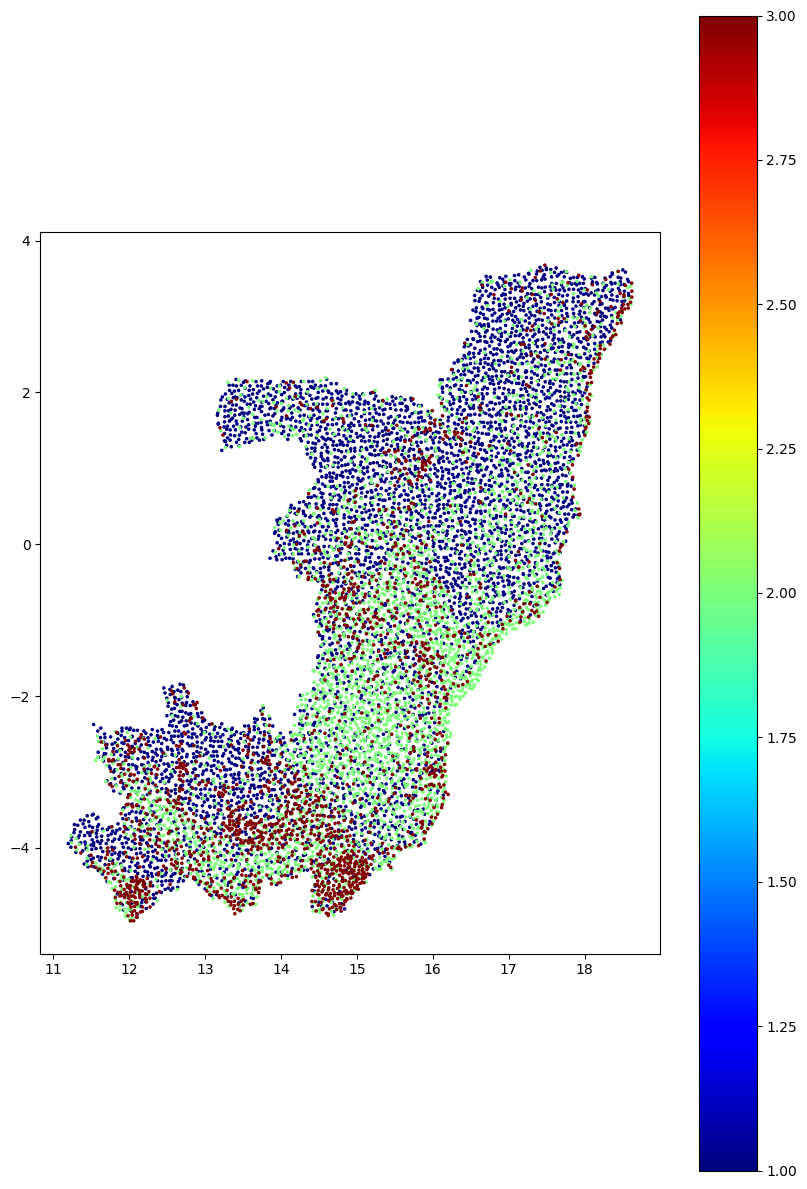

In [48]:
samples.plot('kmeans_chg_1520', markersize=2.5, cmap='jet', legend=True, figsize=(10,15))

### 3. align column names, get coordinates and randomize plotids for CEO


In [49]:
joined_df['PLOTID'] = joined_df['point_id']

In [50]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### we want plotids in random order for CEO

In [51]:
joined_df = joined_df.sample(frac=1).reset_index(drop=True)
joined_df = joined_df.rename(columns={"PLOTID": "OLD_PLOTID"})
start_id = joined_df["OLD_PLOTID"].max() + 1
joined_df["PLOTID"] = range(start_id, start_id + len(joined_df))

In [ ]:
# if you want to export to QGIS
#samples.drop(['ts', 'dates','geometry_x','geometry_y'], axis=1).to_file('gabon_esbae_points_v1.gpkg', driver='GPKG')
#samples.to_file('cog_esbae_points_v1.gpkg', driver='GPKG')

In [52]:
len(samples)

9999

In [53]:
samples.head()

,index,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,...,simple_combined,kmeans_chg,kmeans_def,kmeans_deg,PLOTID,LON,LAT,kmeans_chg_1520,stratum,dist
37,118625,58,38,-1.000,0.000000,0.000000,2018.386,0.072473,3790.184211,9252.730263,...,0.132000,1,1,2,595418,12.021353,-4.825800,1,1,23226154
75,103530,61,44,2017.049,6283.041504,1.452147,2020.249,0.300135,48225.693182,-1116.751894,...,0.129333,1,2,1,594938,11.926173,-4.816132,1,1,24290456
113,109815,65,48,2023.951,-1215.422974,-67.794441,2016.373,0.428137,39829.688889,-5794.678472,...,0.130667,1,2,1,594684,11.911026,-4.748911,1,1,25249641
151,101525,59,42,2016.899,-372.641418,-0.309347,2022.329,0.057756,24046.348413,5433.684127,...,0.125333,1,2,2,595250,12.031167,-4.729791,1,1,26419479
189,122656,64,46,-1.000,0.000000,0.000000,2019.351,0.339735,31354.889855,3643.843478,...,0.133333,1,2,2,594858,12.030846,-4.576144,1,1,27452318


In [54]:
columns = samples.columns.tolist()
print(columns)

['index', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'e

In [55]:
samples_cols = ['PLOTID','LON', 'LAT', 'index', 'images', 'mon_images', 
                'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
                'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 
                'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
                'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
                'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
                'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 
                'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
                'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
                'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
                'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
                'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
                'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 
                'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
                'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
                'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
                'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 
                'geometry', 'point_id', 'Change_Bin', 'Def_Bin', 'Deg_Bin', 'CAFI_LC_2015', 'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520', 'simple_combined', 'kmeans_chg', 'kmeans_def', 'kmeans_deg', 'PLOTID', 'LON', 'LAT', 'kmeans_chg_1520', 'dist'
       ]

### 4. only export first batch of samples once - only overwrite if you have a backup

In [13]:
# export data to .csv
#samples_out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_samples_v1.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_samples_v1.csv'
samples_out_file =  '/home/sepal-user/module_results/esbae/COG/COG_esbae_samples_v1.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/CMR/CMR_esbae_samples_v1.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/EQG/EQG_esbae_samples_v1.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/CAR/CAR_esbae_samples_v1.csv'
#samples[samples_cols].to_csv(samples_out_file,index=False)

### 4. Extraction additional samples for CEO
##### this section is for adding new samples from strata 2 and 3 to intensify visual interprestation in change areas, while avoiding any duplicates with batch 1
##### this is only relevant if you have already completed the first CEO data collection and wish to add more CEO projects to reduce uncertainties

### load any other samples

In [ ]:
#batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_samples_v1.csv')
#batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_samples_v1.csv')
batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_samples_v1.csv')
#batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_samples_v1.csv')
#batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_samples_v1.csv')
#batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_samples_v1.csv')

len(batch1["PLOTID"])

In [ ]:
batch1.columns

In [ ]:
#selection = samples[]
#set() in set()
doublon = set(samples["point_id"]).intersection(batch1["point_id"])
np.unique(doublon, return_counts=True)
len(doublon)

In [ ]:
np.unique(samples["stratum"], return_counts=True)

#### if there are batches already join them all

In [ ]:
#batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_samples_v2.csv')
#batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_samples_v2.csv')
batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_samples_v2.csv')
#batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_samples_v2.csv')
#batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_samples_v2.csv')
#batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_samples_v2.csv')
len(batch2["PLOTID"])

In [ ]:
batch2 = batch2.rename(columns={'Strata': 'stratum'})

In [ ]:
merged_batch = pd.concat([batch1, batch2])
#merged_batch = pd.concat([batch1, batch2,batch3, batch4, batch5])
len(merged_batch)

In [ ]:
merged_batch.columns

In [ ]:
#for 2 batches
#selection = samples[]
#set() in set()
doublon = set(samples["PLOTID"]).intersection(merged_batch["PLOTID"])
np.unique(doublon, return_counts=True)
len(doublon)

#### check for duplicates with previous batches and remove them

In [ ]:
selection = samples[samples["stratum"] > 1]
len(selection)

In [ ]:
sel_ids = set(selection["point_id"]) - set(merged_batch["point_id"])
len(sel_ids)

In [ ]:
doublon = set(selection["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
doublon = set(batch1["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
sel_final = selection[selection["point_id"].isin(sel_ids)]

In [ ]:
len(sel_final)

In [ ]:
sel_final.head()

### 5. export a new batch of samples for CEO

In [ ]:
#give a new name to the samples (v2, v3 etc...)
#amples_out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_samples_v2.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_samples_v2.csv'
samples_out_file =  '/home/sepal-user/module_results/esbae/COG/COG_esbae_samples_v2.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/EQG/EQG_esbae_samples_v2.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/CMR/CMR_esbae_samples_v2.csv'
#samples_out_file =  '/home/sepal-user/module_results/esbae/CAR/CAR_esbae_samples_v2.csv'

sel_final.to_csv(samples_out_file,index=False)